<a href="https://colab.research.google.com/github/daotrananhtuan09102002/CS231.M22.KHCL-Project/blob/master/Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 14 kB/s 
     |████████████████████████████████| 47.6 MB 1.3 MB/s 


In [ ]:
!git clone https://github.com/daotrananhtuan09102002/CS231.M22.KHCL-Project.git

Cloning into 'CS231.M22.KHCL-Project'...
remote: Enumerating objects: 2204, done.
remote: Counting objects: 100% (2204/2204), done.
remote: Compressing objects: 100% (2166/2166), done.
remote: Total 2204 (delta 88), reused 2134 (delta 34), pack-reused 0
Receiving objects: 100% (2204/2204), 30.58 MiB | 35.07 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
!zip -r Temp.zip /content/Temp

In [ ]:
!zip -r HaarResult.zip HaarResult

In [ ]:
!zip -r HandcraftResult.zip HandcraftResult

In [ ]:
import numpy as np
import imutils
import cv2
import easyocr
import time
import os
import tqdm
import PIL
import pandas as pd
import string
import argparse
import warnings
warnings.filterwarnings('ignore')

from PIL import ImageDraw
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from imutils import paths

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!nvidia-smi

Mon May 30 14:30:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |   1603MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# VERSION 1: HANDCRAFT ALGORITHM

## ANPR


In [ ]:
class PyImageSearchANPR:
    def __init__(self, minAR=1.1, maxAR=1.6, minContourArea=1000):
        # initialize parameter
        self.minAR = minAR
        self.maxAR = maxAR
        self.minContourArea = minContourArea

    def locate_license_plate_candidates(self, gray, keep=5):
        # perform a blackhat morphological operation that will allow
        # us to reveal dark regions (i.e., text) on light backgrounds
        # (i.e., the license plate itself)

        # tăng độ tương phản cho ảnh xám
        rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
        topHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKern)
        blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
        gray = cv2.add(gray, topHat)
        gray = cv2.subtract(gray, blackHat)


        # next, find regions in the image that are light
        # tìm những vùng trong ảnh có màu sắc trắng
        squareKern = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
        light = cv2.threshold(light, 0, 255,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
        # compute the Scharr gradient representation of the blackhat
        # image in the x-direction and then scale the result back to
        # the range [0, 255]
        gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F,
                          dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
        gradX = gradX.astype("uint8")

        # blur the gradient representation, applying a closing
        # operation, and threshold the image using Otsu's method
        gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
        thresh = cv2.threshold(gradX, 0, 255,
                               cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        # perform a series of erosions and dilations to clean up the
        # thresholded image
        thresh = cv2.erode(thresh, None, iterations=3) # 3
        thresh = cv2.dilate(thresh, None, iterations=3) # 3

        # take the bitwise AND between the threshold result and the
        # light regions of the image
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)

        thresh = cv2.dilate(thresh, None, iterations=3) # 3
        thresh = cv2.erode(thresh, None, iterations=1)  # 1

        # find contours in the thresholded image and sort them by
        # their size in descending order, keeping only the largest
        # ones
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]

        return gray, cnts, thresh

    def locate_license_plate(self, gray, candidates):
        lpCnt = []

        for c in candidates:
            # tính toán kích thước của contour
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)
            # print(ar)

            # kiểm tra kích thước contour có phù hợp không
            if self.minAR <= ar <= self.maxAR and w * h > self.minContourArea:
                lpCnt.append(c)

        return lpCnt

    def find_best_result_of_lp(self, image):
        # convert the input image to grayscale, locate all candidate
        # license plate regions in the image, and then process the
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray, candidates, thresh = self.locate_license_plate_candidates(gray)
        lpCnt = self.locate_license_plate(gray, candidates)
        if len(lpCnt) == 0:
            return [], []

        ROI_list = []
        for i in lpCnt:
            # hien thi vung bien so chinh xac nhat
            rect = cv2.minAreaRect(i)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            # cv2.drawContours(img, [box], -1, (0, 255, 0), 2)
            # cv2.imshow("Output", img)

            # cat anh de doc chu
            W = rect[1][0]
            H = rect[1][1]

            Xs = [i[0] for i in box]
            Ys = [i[1] for i in box]
            x1 = min(Xs)
            x2 = max(Xs)
            y1 = min(Ys)
            y2 = max(Ys)

            angle = rect[2]
            if angle > 45:
                angle -= 90

            # xoay ảnh
            center = ((x1 + x2) / 2, (y1 + y2) / 2)
            # Size of the upright rectangle bounding the rotated rectangle
            size = (x2 - x1, y2 - y1)
            M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1.0)
            # Cropped upright rectangle
            cropped = cv2.getRectSubPix(gray, size, center)
            cropped = cv2.warpAffine(cropped, M, size)
            croppedW = H if H > W else W
            croppedH = H if H < W else W
            # Final cropped & rotated rectangle
            ROI = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0] / 2, size[1] / 2))
            ROI = imutils.resize(ROI, width=200)
            ROI_list.append(ROI)

        return lpCnt, ROI_list

## CHARACTER SEGMENTATION

In [ ]:
reader = easyocr.Reader(['en'], gpu=True)

MIN_RATIO_AREA = 0.015
MAX_RATIO_AREA = 0.07
MIN_RATIO = 2
MAX_RATIO = 6


def KMeans_(img, n_clusters=3):
    nrow, ncol = img.shape
    g = img.reshape(nrow * ncol, -1)
    k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(g)
    t = k_means.cluster_centers_[k_means.labels_]
    img_res = t.reshape(nrow, ncol)
    img_res = img_res.astype(np.uint8)
    return img_res


class character_segmentation:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters

    def segment(self, img):
        # read text from license plate image with segmentation

        height, width = img.shape
        # use KMeans to segment image into 3 clusters
        seg_img = KMeans_(img, self.n_clusters)
        area = seg_img.shape[0] * seg_img.shape[1]
        seg_img = seg_img.astype(np.uint8)

        # binarize image
        ret, thresh = cv2.threshold(seg_img, 100, 255, cv2.THRESH_BINARY)
        blur = cv2.GaussianBlur(thresh, (5, 5), 0)
        im_bw = cv2.Canny(blur, 10, 200)


        img_BGR = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]

        new_contours = []

        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            # print('Cnt area:', w * h, 'ratio', h / w)
            # remain only contours with area between MIN_RATIO_AREA and MAX_RATIO_AREA
            # and ratio between MIN_RATIO and MAX_RATIO
            if MIN_RATIO_AREA * area <= w * h <= MAX_RATIO_AREA * area \
                    and MIN_RATIO <= h / w <= MAX_RATIO:
                new_contours.append(c)

        chars = []
        X, Y = [], []
        # segment image into characters
        for c in new_contours:
            (x, y, w, h) = cv2.boundingRect(c)

            # padding to help with OCR accuracy
            x_cut = x - 5 if x - 5 > 0 else 0
            y_cut = y - 5 if y - 5 > 0 else 0
            w_cut = w + 5 if x + w + 10 < width else w
            h_cut = h + 5 if y + h + 10 < height else h

            if x_cut == 0 or x + w_cut == width:
                continue
            chars.append(img[y_cut:y + h_cut, x_cut:x + w_cut])
            X.append(x)
            Y.append(y)

        s_top, s_bottom = [], []
        chars_top = []
        chars_bottom = []

        # divide characters into top and bottom by y-coordinate
        for i, c in enumerate(chars):
            if Y[i] < height / 2 - 30:
                chars_top.append([c, X[i], Y[i]])
            else:
                chars_bottom.append([c, X[i], Y[i]])

        # divide top and bottom characters into two groups by x-coordinate
        chars_top = sorted(chars_top, key=lambda x: x[1])
        chars_bottom = sorted(chars_bottom, key=lambda x: x[1])

        #
        if len(chars_top) < 4:
            for i in range(len(chars_top)):
                h, w = chars_top[i][0].shape[:2]
                s = reader.recognize(chars_top[i][0], detail=0, allowlist='0123456789ABCDEFGHKLMNPRSTUVXYZ')
                s_top.append(*s)
        else:
            for i in range(len(chars_top)):
                h, w = chars_top[i][0].shape[:2]
                if i == 2:
                    s = reader.recognize(chars_top[i][0], detail=0, allowlist='ABCDEFGHKLMNPRSTUVXYZ')
                else:
                    s = reader.recognize(chars_top[i][0], detail=0, allowlist='0123456789')
                s_top.append(*s)

        for i in range(len(chars_bottom)):
            h, w = chars_bottom[i][0].shape[:2]
            s = reader.recognize(chars_bottom[i][0], detail=0, allowlist='0123456789')
            s_bottom.append(*s)


        return ''.join(s_top) + '\n' + ''.join(s_bottom)

    def no_segment(self, img):
        # read text from license plate image without segmentation
        s = reader.readtext(img, detail=0, allowlist='0123456789ABCDEFGHKLMNPRSTUVXYZ.-')
        for i in range(len(s)):
            try:
                s[i] = s[i].replace('.', '')
                s[i] = s[i].replace('-', '')
            except:
                continue

        return '\n'.join(s)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

## OCR LICENSE PLATE

In [ ]:
def handcraft(input, segmentation = 1):
    # initialize our ANPR class
    anpr = PyImageSearchANPR()
    seg_anpr = character_segmentation(n_clusters=3)

    # grab all image paths in the input directory
    imagePaths = sorted(list(paths.list_images(input)))
    
    # loop over all image paths in the input directory
    count = 0
    start = time.time()

    for _, imagePath in enumerate(tqdm.tqdm_notebook(imagePaths), start=1):
        # load the input image from disk and resize it
        image = cv2.imread(imagePath)
        image = imutils.resize(image, width=600)

        # apply automatic license plate recognition
        lpCnt, ROI_list = anpr.find_best_result_of_lp(image)
        # print('----------------------------------------------')
        # print(f'Processing image: {_}')

        if len(lpCnt) == 0:
            cv2.putText(image, "Can't detect license plate", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            continue

        flag = False

        # if segmentation is enabled, use character segmentation to extract characters from license plate
        if segmentation == 1:
            for (i, r) in enumerate(ROI_list):
                char = seg_anpr.segment(r)
                if len(char) > 2:
                    count += 1

                    x, y, w, h = cv2.boundingRect(lpCnt[i])
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    cv2.putText(image, '{}'.format(char.replace('\n', '-')),
                                 (x - 15, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)
                    flag = True

        # if segmentation is disabled, don't use character segmentation to extract characters from license plate
        elif segmentation == 0:
            for (i, r) in enumerate(ROI_list):
                char = seg_anpr.no_segment(r)
                if len(char) > 2:
                    count += 1
                    x, y, w, h = cv2.boundingRect(lpCnt[i])
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    cv2.putText(image, '{}'.format(char.replace('\n', '-')),
                                (x - 15, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)

                    flag = True
        if flag is False:
            cv2.putText(image, "Can't recognize character", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

In [ ]:
%prun -D handcraft_segmentation.prof handcraft(input='/content/CS231.M22.KHCL-Project/GreenParking', segmentation=1)

  0%|          | 0/1747 [00:00<?, ?it/s]

 
*** Profile stats marshalled to file 'handcraft_segmentation.prof'. 


## EVALUATION

In [ ]:
with open('/content/CS231.M22.KHCL-Project/location.txt', 'r') as location:
    line = location.readlines()

    array = [i.split() for i in line]
    image_name = [i[0] for i in array]
    true_plate_number = [i[-1] for i in array]
    true_bbox = [[i[2], i[3], i[4], i[5]] for i in array]

In [ ]:
def IoU(bbox1, bbox2):
    # determine the (x, y)-coordinates of the intersection rectangle
	xA = max(bbox1[0], bbox2[0])
	yA = max(bbox1[1], bbox2[1])
	xB = min(bbox1[2], bbox2[2])
	yB = min(bbox1[3], bbox2[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	bbox1Area = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
	bbox2Area = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(bbox1Area + bbox2Area - interArea)
 
	# return the intersection over union value
	return iou

In [ ]:
def computeIoU(orignal_image, resized_image, x, y, w, h, t_bbox):
    shape_before = orignal_image.shape[:2]
    shape_after = resized_image.shape[:2]

    pred_bbox = [x, y, x + w, y + h]

    x_true, y_true, w_true, h_true = list(map(int, t_bbox))

    Rx = shape_after[1] / shape_before[1]
    Ry = shape_after[0] / shape_before[0]

    gt_bbox = [Rx * x_true, Ry * y_true, Rx * (x_true + w_true), Ry * (y_true + h_true)]
    gt_bbox = list(map(int, gt_bbox))
    
    # pred bbox
    cv2.rectangle(resized_image, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), 
                        color=(0, 255, 0), thickness=2)
    
    # # ground truth bbox
    # cv2.rectangle(resized_image, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), 
    #                     color=(0, 0, 255), thickness=2)
                    

    return IoU(gt_bbox, pred_bbox)


In [ ]:
def handcraft_eval(data, segmentation):
    # initialize our ANPR class
    anpr = PyImageSearchANPR()
    seg_anpr = character_segmentation(n_clusters=3)

    for name, t_bbox, t_number in tqdm.tqdm_notebook(list(zip(image_name, true_bbox, true_plate_number))):
        if name not in ['0056_05671_b.jpg']:
            continue

        # load the input image from disk and resize it
        original_image = cv2.imread(os.path.join('/content/CS231.M22.KHCL-Project/GreenParking/', name))
    
        resized_image = imutils.resize(original_image, width=600)

        # apply automatic license plate recognition
        lpCnt, ROI_list = anpr.find_best_result_of_lp(resized_image)

        if len(lpCnt) == 0:
            # cv2.putText(resized_image, "Can't detect license plate", (10, 30),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            data.append([name, None, None])
            continue

        flag = False

        # if segmentation is enabled, use character segmentation to extract characters from license plate
        if segmentation == 1:
            for (i, r) in enumerate(ROI_list):
                char = seg_anpr.segment(r)
                if len(char) > 2:
                    

                    iou = computeIoU(original_image, resized_image, x, y, w, h, t_bbox)
                    
                    char = char.replace('\n', '-')
                    
                    # cv2.putText(resized_image, char,
                    #             (x - 15, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)
                    
                    if char == t_number:
                        data.append([name, iou, 1])
                    else:
                        data.append([name, iou, 0])

                    # cv2_imshow(resized_image)
                    flag = True

        # if segmentation is disabled, don't use character segmentation to extract characters from license plate
        elif segmentation == 0:
            for (i, r) in enumerate(ROI_list):
                char = seg_anpr.no_segment(r)
                if len(char) > 2:
                    x, y, w, h = cv2.boundingRect(lpCnt[i])

                    iou = computeIoU(original_image, resized_image, x, y, w, h, t_bbox)

                    char = char.replace('\n', '-')

                    # cv2.putText(resized_image, char,
                    #             (x - 15, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)
                    
                    if char == t_number:
                        data.append([name, iou, 1])
                    else:
                        data.append([name, iou, 0])

                    # cv2_imshow(resized_image)
                    flag = True

        if flag is False:
            # cv2.putText(resized_image, "Can't recognize character", (10, 30),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)    
            data.append([name, 0, None])

### No Segmentation

In [ ]:
data_no_segmentation = []
handcraft_eval(data_no_segmentation, segmentation=0)

  0%|          | 0/1747 [00:00<?, ?it/s]

In [ ]:
df_no_segmentation = pd.DataFrame(data_no_segmentation, columns=['Image Name', 'IoU', 'Character Accuracy'])

In [ ]:
df_no_segmentation.to_csv('Handcraft_no_segmentation.csv', index=False)

In [ ]:
df_no_segmentation.describe()

,IoU,Character Accuracy
count,1572.000000,1535.000000
mean,0.757287,0.518567
std,0.215873,0.499818
min,0.000000,0.000000
25%,0.769721,0.000000
50%,0.820575,1.000000
75%,0.858234,1.000000
max,0.966838,1.000000


In [ ]:
TP = len(df_no_segmentation[df_no_segmentation.IoU >= 0.5])
FP = len(df_no_segmentation[df_no_segmentation['IoU'] < 0.5])
FN = df_no_segmentation['IoU'].isna().sum()

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1 score: {F1}')

Precision: 0.9185750636132316
Recall: 0.8672672672672672
F1 score: 0.8921841210997837


In [ ]:
df_no_segmentation['Character Accuracy'].value_counts()  / df_no_segmentation['IoU'].count()

1.0    0.506361
0.0    0.470102
Name: Character Accuracy, dtype: float64

### With segmentation

  0%|          | 0/1747 [00:00<?, ?it/s]

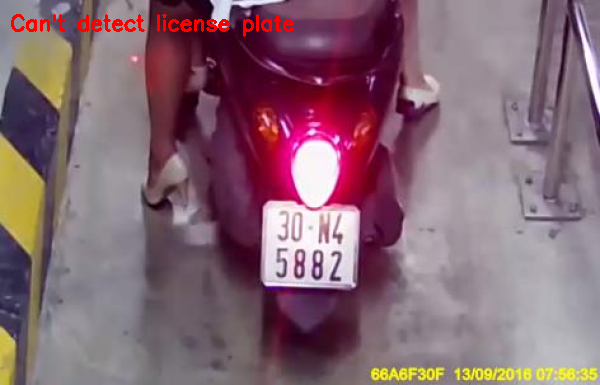

In [ ]:
data_segmentation = []
handcraft_eval(data_segmentation, segmentation=1)

In [ ]:
df_segmentation = pd.DataFrame(data_segmentation, columns=['Image Name', 'IoU', 'Character Accuracy'])

In [ ]:
df_segmentation.to_csv('Handcraft_segmentation.csv', index=False)

In [ ]:
df_segmentation.describe()

,IoU,Character Accuracy
count,1540.000000,1467.000000
mean,0.765468,0.578732
std,0.205377,0.493931
min,0.000000,0.000000
25%,0.775922,0.000000
50%,0.821771,1.000000
75%,0.858825,1.000000
max,0.966838,1.000000


In [ ]:
TP = len(df_segmentation[df_segmentation['IoU'] >= 0.5])
FP = len(df_segmentation[df_segmentation['IoU'] < 0.5])
FN = df_segmentation['IoU'].isna().sum()

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1 score: {F1}')

Precision: 0.9298701298701298
Recall: 0.8663036902601331
F1 score: 0.8969621046038209


In [ ]:
df_segmentation['Character Accuracy'].value_counts()  / df_segmentation['IoU'].count()

1.0    0.551299
0.0    0.401299
Name: Character Accuracy, dtype: float64

# testing


# VERSION 2: HARCASCADE


## ANPR


In [ ]:
nPlateCascade = cv2.CascadeClassifier(r'/content/CS231.M22.KHCL-Project/ANPR_Ver.2/resources/haarcascade_motor_license_plate.xml')
reader = easyocr.Reader(['en'], gpu=True)
minArea = 150

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:
imagePaths = sorted(list(paths.list_images('/content/CS231.M22.KHCL-Project/GreenParking')))

In [ ]:
def process_number(char):
    temp = [row.translate(str.maketrans('', '', string.punctuation)) for row in char]
    return '-'.join(temp)

In [ ]:
def detect_license_plate(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    box_plates = nPlateCascade.detectMultiScale(imgGray, scaleFactor=1.1, minNeighbors=3, flags=cv2.CASCADE_SCALE_IMAGE)

    plate = None   

    for (x, y, w, h) in box_plates:
        plate = img[y:y+h, x:x + w]

    if len(box_plates) == 0:
      return img, plate, None
    else:
      return img, plate, [x, y, x + w, y + h]

In [ ]:
def haarcascade(imagePaths):
    for _, imagePath in enumerate(tqdm.tqdm_notebook(imagePaths), start=1):
        image = cv2.imread(imagePath)

        image = imutils.resize(image, width=600)

        image, plate, pred_bbox = detect_license_plate(image)

        if plate is not None:
            # pred bbox
            cv2.rectangle(image, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), 
                                color=(0, 255, 0), thickness=2)
            
            # plate_gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
            # char = reader.readtext(plate_gray, detail=0, allowlist='0123456789ABCDEFGHKLMNPRSTUVXYZ-.')
            # char = process_number(char)

            # cv2.putText(image, char, (pred_bbox[0] - 15, pred_bbox[1] - 15),
            #         cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)    

            # cv2_imshow(image)


In [ ]:
%prun -D haar.prof haarcascade(imagePaths)

  0%|          | 0/1747 [00:00<?, ?it/s]

 
*** Profile stats marshalled to file 'haar.prof'. 


## EVALUATION

In [ ]:
with open('location.txt', 'r') as location:
    line = location.readlines()

    array = [i.split() for i in line]
    image_name = [i[0] for i in array]
    true_plate_number = [i[-1] for i in array]
    true_bbox = [[i[2], i[3], i[4], i[5]] for i in array]

In [ ]:
def IoU(bbox1, bbox2):
    # determine the (x, y)-coordinates of the intersection rectangle
	xA = max(bbox1[0], bbox2[0])
	yA = max(bbox1[1], bbox2[1])
	xB = min(bbox1[2], bbox2[2])
	yB = min(bbox1[3], bbox2[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	bbox1Area = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
	bbox2Area = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(bbox1Area + bbox2Area - interArea)
 
	# return the intersection over union value
	return iou

In [ ]:
%rm /content/OpenALPRHaar/*

In [ ]:
data = []
for name, t_bbox, t_number in tqdm.tqdm_notebook(list(zip(image_name, true_bbox, true_plate_number))):
    
    image = cv2.imread(os.path.join('/content/CS231.M22.KHCL-Project/GreenParking/', name))

    shape_before = image.shape[:2]
    image = imutils.resize(image, width=600)
    shape_after = image.shape[:2]

    image, plate, pred_bbox = detect_license_plate(image)

    # print('------------------------------------------------------')
    # print(f'Processing image: {i}')

    if plate is not None:
        x_true, y_true, w_true, h_true = list(map(int, t_bbox))
        Rx = shape_after[1] / shape_before[1]
        Ry = shape_after[0] / shape_before[0]
        gt_bbox = [Rx * x_true, Ry * y_true, Rx * (x_true + w_true), Ry * (y_true + h_true)]
        gt_bbox = list(map(int, gt_bbox))

        iou = IoU(gt_bbox, pred_bbox)
        # print(iou)

        # pred bbox
        cv2.rectangle(image, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), 
                            color=(0, 255, 0), thickness=2)
        
        # ground truth bbox
        cv2.rectangle(image, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), 
                            color=(0, 0, 255), thickness=2)

        
        plate_gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        char = reader.readtext(plate_gray, detail=0, allowlist='0123456789ABCDEFGHKLMNPRSTUVXYZ-.')

        char = process_number(char)
        cv2.putText(image, char,
                (pred_bbox[0] - 15, pred_bbox[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)

        cv2.imwrite(f'/content/OpenALPRHaar/{name}.jpg', image)
        # cv2_imshow(image) 


        if char == t_number:
            data.append([name, iou, 1])
        else:
            data.append([name, iou, 0]) 
            
    else:
        data.append([name, None, None])
      # cv2_imshow(image)

  0%|          | 0/1747 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(data, columns = ['Name', 'IoU', 'Character Accuracy'])
df

,Name,IoU,Character Accuracy
0,0000_00532_b.jpg,NaN,NaN
1,0000_02187_b.jpg,NaN,NaN
2,0000_05696_b.jpg,0.798987,1.0
3,0000_06886_b.jpg,NaN,NaN
4,0000_08244_b.jpg,NaN,NaN
...,...,...,...
1742,0520_06296_b.jpg,NaN,NaN
1743,0520_07389_b.jpg,NaN,NaN
1744,0521_04268_b.jpg,0.772487,0.0
1745,0521_04658_b.jpg,NaN,NaN


In [ ]:
df.to_csv('Haarcascde scaleFactor 1,1.csv',index=False)

In [ ]:
# df = pd.read_csv('/content/Haarcascde scaleFactor 1,1.csv')
df

,Name,IoU,Character Accuracy
0,0000_00532_b.jpg,NaN,NaN
1,0000_02187_b.jpg,NaN,NaN
2,0000_05696_b.jpg,0.798987,1.0
3,0000_06886_b.jpg,NaN,NaN
4,0000_08244_b.jpg,NaN,NaN
...,...,...,...
1742,0520_06296_b.jpg,NaN,NaN
1743,0520_07389_b.jpg,NaN,NaN
1744,0521_04268_b.jpg,0.772487,0.0
1745,0521_04658_b.jpg,NaN,NaN


In [ ]:
df.describe()

,IoU,Character Accuracy
count,850.000000,850.000000
mean,0.774491,0.301176
std,0.032300,0.459039
min,0.643067,0.000000
25%,0.756287,0.000000
50%,0.774108,0.000000
75%,0.795003,1.000000
max,0.886766,1.000000


In [ ]:
TP = len(df[df.IoU >= 0.5])
FP = len(df[df['IoU'] < 0.5])
FN = df['IoU'].isna().sum()

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1 score: {F1}')

Precision: 1.0
Recall: 0.48654836863194045
F1 score: 0.6546014632268001


In [ ]:
df['Character Accuracy'].value_counts() / df['Character Accuracy'].count()

0.0    0.770332
1.0    0.229668
Name: Character Accuracy, dtype: float64

# test


In [ ]:
imagePaths = sorted(list(paths.list_images('/content/CS231.M22.KHCL-Project/GreenParking')))

In [ ]:
def test(imagePaths):
    array = []
    for _, imagePath in enumerate(tqdm.tqdm_notebook(imagePaths), start=1):
        im = PIL.Image.open(imagePath).convert('L')
        stat = PIL.ImageStat.Stat(im)
        head, tail = os.path.split(imagePath)
        array.append([tail, stat.mean[0], stat.count[0]])
    return array

In [ ]:
a = pd.DataFrame(test(imagePaths), columns=['Image Name', 'Image Brightness', 'Pixel Count'])

  0%|          | 0/1747 [00:00<?, ?it/s]

In [ ]:
a.describe()

,Image Brightness,Pixel Count
count,1747.000000,1747.0
mean,111.302155,143016.0
std,7.597451,0.0
min,83.033898,143016.0
25%,106.213962,143016.0
50%,111.338144,143016.0
75%,116.093129,143016.0
max,140.064678,143016.0


Image Name          0000_00532_b.jpg
Image Brightness           83.033898
Pixel Count                   143016
dtype: object


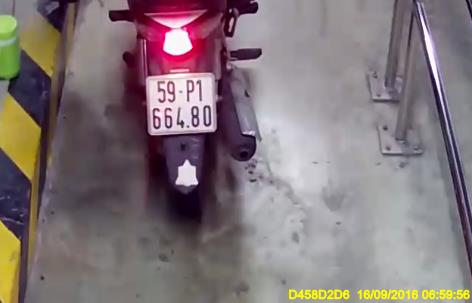

In [ ]:
print(a.min())
cv2_imshow(cv2.imread(f'/content/CS231.M22.KHCL-Project/GreenParking/{a.min()["Image Name"]}'))

Image Name          0521_05656_b.jpg
Image Brightness          140.064678
Pixel Count                   143016
dtype: object


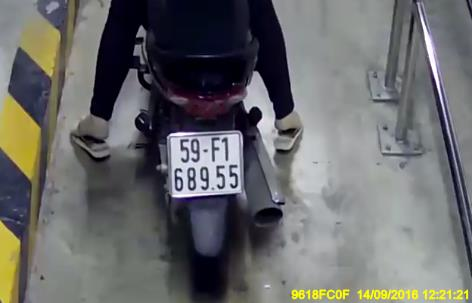

In [ ]:
print(a.max())
cv2_imshow(cv2.imread(f'/content/CS231.M22.KHCL-Project/GreenParking/{a.max()["Image Name"]}'))

In [ ]:
internet = sorted(list(paths.list_images('/content/CS231.M22.KHCL-Project/license_plate')))

In [ ]:
b = pd.DataFrame(test(internet), columns=['Image Name', 'Image Brightness', 'Pixel Count'])

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
b.describe()

,Image Brightness,Pixel Count
count,7.000000,7.000000
mean,106.474562,300000.000000
std,7.033064,79372.539332
min,96.951100,270000.000000
25%,102.584839,270000.000000
50%,104.277381,270000.000000
75%,110.387196,270000.000000
max,118.149378,480000.000000


In [ ]:
b

,Image Name,Image Brightness,Pixel Count
0,0412.jpg,96.951100,270000
1,0413.jpg,101.302252,270000
2,0421.jpg,104.277381,270000
3,0429.jpg,111.016204,270000
4,0472.jpg,118.149378,270000
5,050110.jpg,109.758189,270000
6,1.jpg,103.867427,480000


# test 2
